# HiPPO Matrices
---

## Load Packages

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
#from functools import partial
#from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
#from einops import rearrange, reduce, repeat
import math
#import requests
from scipy import linalg as la
from scipy import signal
from scipy import special as ss
device = torch.device("cpu")
print(f"The Device: {device}")

print(f"MPS enabled: {torch.backends.mps.is_available()}")

The Device: cpu
MPS enabled: False


In [3]:
## import packages
import math

import requests

from scipy import linalg as la
from scipy import signal
from scipy import special as ss

from src.data.process import moving_window, rolling_window
#import modules 
from src.models.hippo.gu_transition import GuTransMatrix
from src.models.hippo.unroll import (basis, measure, variable_unroll_matrix,
                                     variable_unroll_matrix_sequential)

device = torch.device("cpu")
print(f"The Device: {device}")

The Device: cpu


In [4]:
torch.set_printoptions(linewidth=150)
np.set_printoptions(linewidth=150)

In [6]:
seed = 1701

### Hippo NN Module

In [ ]:
class HIPPO_LEGS(nn.Module):
    """Hippo class utilizing legs polynomial"""

    def __init__(self, N, gbt_alpha = 0.5, maxlength = 1024):
        super(HIPPO_LEGS, self).__init__()
        self.N = N
        self.gbt_alpha = gbt_alpha
        self.maxlength = maxlength
        
    def compute_A(self, n, k):
        '''
        Computes the values for the HiPPO A matrix row by column 
        using the piecewise equation on p. 31 eq. 29:
                (2n+1)^{1/2} (2k+ 1)^{1/2} if n > k  
        A_{nk} = n+1                       if n = k,
                 0                         if n < k
        , where n represents the row and k the columns. 
        
        Input:
            n (int):
                nth row of a square matrix of size N
            k (int):
                kth column of a square matrix of size N
        
        Returns:
            Values (float):
            Individual values for the elements in the A matrix. 
        '''
        if n > k:
            val = np.sqrt(2 * n + 1, dtype = np.float32) * np.sqrt(2 * k + 1, dtype = np.float32)
        if n == k:
            val = n + 1 
        if n < k:
            val = 0
        return val

    def compute_B(self, n):
        '''
        Computes the values for the HiPPO B matrix row by column 
        using the piecewise equation on p. 31 eq. 29:
        B_{n} = (2n+1)^{1/2}
        
        Input:
            n (int):
                nth column of a square matrix of size N.
            
        Returns:
            Values (float):
            Individual values for the elements in the B matrix.
            The next hidden state (aka coefficients representing the function, f(t))
        '''
        val = np.sqrt(2 * n + 1, dtype = np.float32)
        return val

    def get_A_and_B(self, N):
        '''
        Creates the HiPPO A and B matrix given the size N along a single axis of 
        a square matrix.
        
        Input: 
            N (int):
            Size N of a square matrix along a single axis.
        
        Returns: 
            A (np.ndarray)
                shape: (N,N)
                the HiPPO A matrix.
            B (np.ndarray)
                shape: (N,):
                The HiPPO B matrix.
        '''
        A = np.zeros((self.N, self.N), dtype = np.float32)
        B = np.zeros((self.N, 1), dtype = np.float32)

        for n in range(A.shape[0]):
            B[n][0] = self.compute_B(n = n)
            for k in range(A.shape[1]):
                A[n, k] = self.compute_A(n = n , k = k)

        return A  * -1, B
    
    def generalized_bilinear_transform(self, A, B, t, gbt_alpha):
        '''
        Performs the generalised bilinaer transform from p. 21 eq.13:
        c(t + ∆t) − ∆tαAc(t + ∆t) = (I + ∆t(1 − α)A)c(t) + ∆tBf(t)
        c(t + ∆t) = (I − ∆tαA)^{−1} (I + ∆t(1 − α)A)c(t) + ∆t(I − ∆tαA)^{−1}Bf(t).
        on the HiPPO matrix A and B, transforming them. 
        Input:
            A (np.ndarray):
                shape: (N, N)
                the HiPPO A matrix
            B (np.ndarray):
                shape: (N,)
                the HiPPO B matrix
            Timestep t = 1/input length at t (int):
        
        Output:
            GBTA (np.array):
                shape: (N, N)
                Transformed HiPPO A matrix.
            
            GBTB (np.array):
                shape: (N,)
                Transformed HiPPO B matrix.
        '''
        I = np.eye(A.shape[0], dtype = np.float32)
        delta_t = 1 / t
        EQ13_p1 = I - (delta_t * gbt_alpha * A)
        EQ13_p2 = I + (delta_t * (1 - gbt_alpha) * A)
        EQA = np.linalg.lstsq(EQ13_p1, EQ13_p2, rcond = None)[0]
        EQB =  np.linalg.lstsq(EQ13_p1, (delta_t * B), rcond = None)[0]         
        return EQA, EQB
    
    def get_stacked_GBT(self):
        A, B = self.get_A_and_B(self.N)
        GBTA_stacked = np.empty((self.maxlength, self.N, self.N), dtype=np.float32)
        GBTB_stacked = np.empty((self.maxlength, self.N, 1), dtype=np.float32)
        
        for t in range(1, self.maxlength + 1):
            GBTA, GBTB = self.generalized_bilinear_transform(A = A, B = B, t = t, gbt_alpha = self.gbt_alpha)
            GBTA_stacked[t-1] = GBTA
            GBTB_stacked[t-1] = GBTB
            
        return GBTA_stacked, GBTB_stacked
    
    def discrete_hippo_operator(self, A, B, inputs, c_t =  None):
        '''
        Input:
            A (np.ndarray):
                shape: (N, N)
                the discretized A matrix
            B (np.ndarray):
                shape: (N, 1)
                the discretized B matrix
            c_t (np.ndarray):
                shape: (batch size, input length, N)
                the initial hidden state
            inputs (torch.tensor):
                shape: (batch size, maxlength)
                the input sequence
        Returns:
            The next hidden state (aka coefficients representing the function, f(t))
        '''
        batchsize = inputs.shape[0]
        L = inputs.shape[1]

        # Change input shape from (batch size, max length)
        # to (max length, batch size, max length)
        # note that max length can also be regarded as the length of the signal
        inputs = torch.tensor(inputs)
        inputs = inputs.T.unsqueeze(-1).unsqueeze(-1)

        lst = []
        
        if c_t is None:
            c_t = np.zeros((batchsize, 1, self.N), dtype = np.float32)
            
        for t, f_t in enumerate(inputs):
            
            #part_1 = F.linear(torch.tensor(c_t).float(), torch.tensor(A[t]).float())
            #part_2 = np.squeeze(B[t], -1) * f_t.numpy()
            #c_t = part_1 + part_2
            
            c_t = F.linear(torch.tensor(c_t).float(), torch.tensor(A[t]).float()) + np.squeeze(B[t], -1) * f_t.numpy()
            lst.append(c_t)
        return np.stack(lst, axis = 0, dtype = np.float32)
    
    def reconstruct(self, c, B):
        vals = np.linspace(0.0, 1.0, self.maxlength)
        # If clause for supporting use of batched raw signal 
        # with batch information of shape [batchsize, maxlength] 
        if len(c.shape) == 4:
            # c shape from: [maxlength, batchsize, 1, N_coeffs]
            # 1st move to: [batchsize, maxlength, 1, N_coeffs]
            # 2nd move to: [batchsize, maxlength, N_coeffs, 1]
            c = np.moveaxis(c, 0, 1)
            c = np.moveaxis(c, 2, 3)
        
        eval_mat = (B * np.float32(ss.eval_legendre(np.expand_dims(np.arange(self.N, dtype = np.float32), -1), 2 * vals - 1))).T
        recon = eval_mat @ np.float32(c)
        return recon
    
    def forward(self, inputs):
        # 1.Compute B, GBTA and GBTA matrices
        # B is needed in 3. for the reconstruction
        # GBTA and GBTA is needed for coefficents c
        _, B = self.get_A_and_B(N = self.N)
        GBTA, GBTB = self.get_stacked_GBT()
        # 2.Compute coefficents c
        c = self.discrete_hippo_operator(A = GBTA, B = GBTB, inputs = inputs, c_t = None)
        # 3. Compute reconstruction r
        r =  self.reconstruct(c = c, B = B)
        return c, r


In [140]:
class HIPPO_LEGS(nn.Module):
    """Hippo class utilizing legs polynomial"""

    def __init__(self, N, gbt_alpha = 0.5, maxlength = 1024):
        super(HIPPO_LEGS, self).__init__()
        self.N = N
        self.gbt_alpha = gbt_alpha
        self.maxlength = maxlength
        
    def compute_A(self, n, k):
        '''
        Computes the values for the HiPPO A matrix row by column 
        using the piecewise equation on p. 31 eq. 29:
                (2n+1)^{1/2} (2k+ 1)^{1/2} if n > k  
        A_{nk} = n+1                       if n = k,
                 0                         if n < k
        , where n represents the row and k the columns. 
        
        Input:
            n (int):
                nth row of a square matrix of size N
            k (int):
                kth column of a square matrix of size N
        
        Returns:
            Values (float):
            Individual values for the elements in the A matrix. 
        '''
        if n > k:
            val = np.sqrt(2 * n + 1, dtype = np.float32) * np.sqrt(2 * k + 1, dtype = np.float32)
        if n == k:
            val = n + 1 
        if n < k:
            val = 0
        return val

    def compute_B(self, n):
        '''
        Computes the values for the HiPPO B matrix row by column 
        using the piecewise equation on p. 31 eq. 29:
        B_{n} = (2n+1)^{1/2}
        
        Input:
            n (int):
                nth column of a square matrix of size N.
            
        Returns:
            Values (float):
            Individual values for the elements in the B matrix.
            The next hidden state (aka coefficients representing the function, f(t))
        '''
        val = np.sqrt(2 * n + 1, dtype = np.float32)
        return val

    def get_A_and_B(self, N):
        '''
        Creates the HiPPO A and B matrix given the size N along a single axis of 
        a square matrix.
        
        Input: 
            N (int):
            Size N of a square matrix along a single axis.
        
        Returns: 
            A (np.ndarray)
                shape: (N,N)
                the HiPPO A matrix.
            B (np.ndarray)
                shape: (N,):
                The HiPPO B matrix.
        '''
        A = np.zeros((self.N, self.N), dtype = np.float32)
        B = np.zeros((self.N, 1), dtype = np.float32)

        for n in range(A.shape[0]):
            B[n][0] = self.compute_B(n = n)
            for k in range(A.shape[1]):
                A[n, k] = self.compute_A(n = n , k = k)

        return A  * -1, B
    
    def generalized_bilinear_transform(self, A, B, t, gbt_alpha):
        '''
        Performs the generalised bilinaer transform from p. 21 eq.13:
        c(t + ∆t) − ∆tαAc(t + ∆t) = (I + ∆t(1 − α)A)c(t) + ∆tBf(t)
        c(t + ∆t) = (I − ∆tαA)^{−1} (I + ∆t(1 − α)A)c(t) + ∆t(I − ∆tαA)^{−1}Bf(t).
        on the HiPPO matrix A and B, transforming them. 
        Input:
            A (np.ndarray):
                shape: (N, N)
                the HiPPO A matrix
            B (np.ndarray):
                shape: (N,)
                the HiPPO B matrix
            Timestep t = 1/input length at t (int):
        
        Output:
            GBTA (np.array):
                shape: (N, N)
                Transformed HiPPO A matrix.
            
            GBTB (np.array):
                shape: (N,)
                Transformed HiPPO B matrix.
        '''
        I = np.eye(A.shape[0], dtype = np.float32)
        delta_t = 1 / t
        EQ13_p1 = I - (delta_t * gbt_alpha * A)
        EQ13_p2 = I + (delta_t * (1 - gbt_alpha) * A)
        EQA = np.linalg.lstsq(EQ13_p1, EQ13_p2, rcond = None)[0]
        EQB =  np.linalg.lstsq(EQ13_p1, (delta_t * B), rcond = None)[0]         
        return EQA, EQB
    
    def get_stacked_GBT(self):
        A, B = self.get_A_and_B(self.N)
        GBTA_stacked = np.empty((self.maxlength, self.N, self.N), dtype=np.float32)
        GBTB_stacked = np.empty((self.maxlength, self.N, 1), dtype=np.float32)
        
        for t in range(1, self.maxlength + 1):
            GBTA, GBTB = self.generalized_bilinear_transform(A = A, B = B, t = t, gbt_alpha = self.gbt_alpha)
            GBTA_stacked[t-1] = GBTA
            GBTB_stacked[t-1] = GBTB
            
        return GBTA_stacked, GBTB_stacked
    
    def discrete_hippo_operator(self, A, B, inputs, c_t =  None):
        '''
        Input:
            A (np.ndarray):
                shape: (N, N)
                the discretized A matrix
            B (np.ndarray):
                shape: (N, 1)
                the discretized B matrix
            c_t (np.ndarray):
                shape: (batch size, input length, N)
                the initial hidden state
            inputs (torch.tensor):
                shape: (batch size, maxlength)
                the input sequence
        Returns:
            The next hidden state (aka coefficients representing the function, f(t))
        '''
        batchsize = inputs.shape[0]
        L = inputs.shape[1]
        print("-------------Input------------")
        print("Ramen inputs shape:", inputs.shape)
        # Change input shape from (batch size, max length)
        # to (max length, batch size, max length)
        # note that max length can also be regarded as the length of the signal
        inputs = torch.tensor(inputs)
        inputs = inputs.T.unsqueeze(-1).unsqueeze(-1)
        print("Ramen inputs shape:", inputs.shape)
        lst = []
        
        if c_t is None:
            c_t = np.zeros((batchsize, 1, self.N), dtype = np.float32)
            
        print("-------------Init------------")
        print("Ramen coef c shape:", c_t.shape)
        print("-------------Init------------")
        switch = True
        for t, f_t in enumerate(inputs):
            
            #part_1 = F.linear(torch.tensor(c_t).float(), torch.tensor(A[t]).float())
            #part_2 = np.squeeze(B[t], -1) * f_t.numpy()
            #c_t = part_1 + part_2
            
            c_t = F.linear(torch.tensor(c_t).float(), torch.tensor(A[t]).float()) + np.squeeze(B[t], -1) * f_t.numpy()
            if switch == True:
                print("----------Ramen F Linear:----------")
                print("Ramen part1 shape:", F.linear(torch.tensor(c_t).float(), torch.tensor(A[t])).shape)
                print("Ramen part2  shape:", (np.squeeze(B[t], -1) * f_t.numpy()).shape)
                print("Ramen A stacked  shape:", A[t].shape)
                print("Ramen B stacked  shape:", np.squeeze(B[t], -1).shape)
                print("Ramen input [f] shape:", f_t.shape)
                print("Ramen Coef  c shape:", c_t.shape)
                switch = False
            #print("our c_t:", c_t.shape)
            lst.append(c_t)
        return np.stack(lst, axis = 0, dtype = np.float32)
    
    def reconstruct(self, c, B):
        vals = np.linspace(0.0, 1.0, self.maxlength)
        print("----------Ramen Reconstruction part:----------")
        # If clause for supporting use of batched raw signal 
        # with batch information of shape [batchsize, maxlength] 
        if len(c.shape) == 4:
            # c shape from: [maxlength, batchsize, 1, N_coeffs]
            # 1st move to: [batchsize, maxlength, 1, N_coeffs]
            # 2nd move to: [batchsize, maxlength, N_coeffs, 1]
            c = np.moveaxis(c, 0, 1)
            print("Ramen Coefs stacked shape:", c.shape)
            c = np.moveaxis(c, 2, 3)
            print("Ramen Coefs stacked shape:", c.shape)
        
        eval_mat = (B * np.float32(ss.eval_legendre(np.expand_dims(np.arange(self.N, dtype = np.float32), -1), 2 * vals - 1))).T
        recon = eval_mat @ np.float32(c)
        print("Ramen Eval mat shape:", eval_mat.shape)
        print("Ramen Coefs stacked shape:", c.shape)
        print("Ramen Recon shape:", recon.shape)
        print("----------------------------------------")
        return recon
    
    def forward(self, inputs):
        # 1.Compute B, GBTA and GBTA matrices
        # B is needed in 3. for the reconstruction
        # GBTA and GBTA is needed for coefficents c
        _, B = self.get_A_and_B(N = self.N)
        GBTA, GBTB = self.get_stacked_GBT()
        # 2.Compute coefficents c
        c = self.discrete_hippo_operator(A = GBTA, B = GBTB, inputs = inputs, c_t = None)
        # 3. Compute reconstruction r
        r =  self.reconstruct(c = c, B = B)
        return c, r


In [24]:
class HiPPO_LSI(nn.Module):
    """Vanilla HiPPO-LegS model (scale invariant instead of time invariant)"""

    def __init__(
        self,
        N,
        method="legs",
        max_length=1024,
        discretization=0.5,
        lambda_n=1.0,
        alpha=0.0,
        beta=1.0,
    ):
        """
        max_length: maximum sequence length
        """
        super().__init__()
        self.N = N
        matrices = GuTransMatrix(
            N=N, measure=method, lambda_n=lambda_n, alpha=alpha, beta=beta
        )
        A = np.asarray(matrices.A, dtype=np.float32)
        B = np.asarray(matrices.B, dtype=np.float32)
        B = B.squeeze(-1)

        A_stacked = np.empty((max_length, N, N), dtype=A.dtype)
        B_stacked = np.empty((max_length, N), dtype=B.dtype)

        for t in range(1, max_length + 1):
            At = A / t
            Bt = B / t
            if discretization == 0.0:  # forward
                A_stacked[t - 1] = np.eye(N) + At
                B_stacked[t - 1] = Bt
            elif discretization == 1.0:  # backward
                A_stacked[t - 1] = la.solve_triangular(
                    np.eye(N) - At, np.eye(N), lower=True
                )
                B_stacked[t - 1] = la.solve_triangular(np.eye(N) - At, Bt, lower=True)
            elif discretization == 0.5:  # bilinear
                # A_stacked[t - 1] = la.solve_triangular(
                #     np.eye(N) - At / 2, np.eye(N) + At / 2, lower=True
                # )
                # B_stacked[t - 1] = la.solve_triangular(
                #     np.eye(N) - At / 2, Bt, lower=True
                # )
                alpha = 0.5
                A_stacked[t - 1] = np.linalg.lstsq(
                    np.eye(N) - (At * alpha), np.eye(N) + (At * alpha), rcond=None
                )[
                    0
                ]  # TODO: Referencing this: https://stackoverflow.com/questions/64527098/numpy-linalg-linalgerror-singular-matrix-error-when-trying-to-solve
                B_stacked[t - 1] = np.linalg.lstsq(
                    np.eye(N) - (At * alpha), Bt, rcond=None
                )[0]
                
            else:  # ZOH
                A_stacked[t - 1] = la.expm(A * (math.log(t + 1) - math.log(t)))
                # A_stacked[t - 1] = la.expm(At)
                B_stacked[t - 1] = la.solve_triangular(
                    A, A_stacked[t - 1] @ B - B, lower=True
                )
                
                # A_stacked[t - 1] = la.expm(At)
                # B_stacked[t - 1] = la.inv(A) @ (la.expm(At) - np.eye(A.shape[0])) @ B
                
                
        # self.register_buffer('A_stacked', torch.Tensor(A_stacked)) # (max_length, N, N)
        # self.register_buffer('B_stacked', torch.Tensor(B_stacked)) # (max_length, N)
        
        self.A_stacked = torch.Tensor(A_stacked.copy())  # (max_length, N, N)
        self.B_stacked = torch.Tensor(B_stacked.copy())  # (max_length, N)

        vals = np.linspace(0.0, 1.0, max_length)
        
        self.eval_matrix = torch.from_numpy(
            np.asarray(
                ((B[:, None] * ss.eval_legendre(np.arange(N)[:, None], 2 * vals - 1)).T)
            )
        )

    def forward(self, inputs, fast=False):
        """
        inputs : (length, ...)
        output : (length, ..., N) where N is the order of the HiPPO projection
        """
        print("-------------Input------------")
        print("Gu inputs shape:", inputs.shape)
        L = inputs.shape[0]
        print("Gu L :", L)
        inputs = inputs.unsqueeze(-1)
        print("Gu inputs shape unsqueeze :", inputs.shape)
        u = torch.transpose(inputs, 0, -2)
        print("Gu signal u transpose :", u.shape)
        print("Gu self.B_stacked shape :", self.B_stacked.shape)
        print("Gu self.B_stacked[:L] shape:", self.B_stacked[:L].shape)
        u = u * self.B_stacked[:L]
        print("Gu signal u mult self.B_stacked[:L] shape:", u.shape)
        u = torch.transpose(u, 0, -2)  # (length, ..., N)
        print("Gu signal u transpose 2:", u.shape)
        if fast:
            result = variable_unroll_matrix(self.A_stacked[:L], u)
            return result

        c = torch.zeros(u.shape[1:]).to(inputs)
        print("Gu c zeros:", c.shape)
        cs = []
        for t, f in enumerate(inputs):
            part1 = F.linear(c, self.A_stacked[t])
            #print("Gu f t shape ",f_t.numpy().shape)
            part2 = self.B_stacked[t] * f
            c = part1 + part2
            print("----------Gu F Linear:----------")
            print("Gu part1 shape:", F.linear(c, self.A_stacked[t]).shape)
            print("Gu part2  shape:", part2.shape)
            print("Gu A stacked  shape:", self.A_stacked[t].shape)
            print("Gu B stacked  shape:", self.B_stacked[t].shape)
            print("Gu input [f] shape:", f.shape)
            print("Gu Coef c shape:", c.shape)
            cs.append(c)
        print("Gu Coef c stacked shape:", torch.stack(cs, dim=0).shape)
        return torch.stack(cs, dim=0)
    
    def reconstruct(self, c):
        a = self.eval_matrix.to(c) @ c.unsqueeze(-1)
        return a


### Test Hippo A and B Matrix

In [43]:
# init HIPPO LEG S
def test_LegS(hippo, N):
    A, B = hippo.get_A_and_B(N=N)
    gu_legs_matrices = GuTransMatrix(N=N, measure="legs")
    gu_A, gu_B = gu_legs_matrices.A, gu_legs_matrices.B
    
    assert A.shape==gu_A.shape, f"Shape mismatch between target {gu_A.shape} and hippo A matrix {A.shape}."
    print(f"Shape between target and computed hippo A matrix are equal:\n{gu_A.shape==A.shape}")
    assert B.shape==gu_B.shape, f"Shape mismatch between target {gu_B.shape} and hippo B matrix {B.shape}."
    print(f"Shape between target and computed hippo B matrix are equal:\n{gu_B.shape==B.shape}")
    assert np.allclose(A, gu_A), f"Hippo A matrix values between target and computed are not equal:\n{np.allclose(A, gu_A)}"
    print(f"Hippo A matrix values between target and computed are equal:\n{np.allclose(A, gu_A)}")
    assert np.allclose(B, gu_B), f"Hippo B matrix values between target and computed are not equal:\n{np.allclose(B, gu_B)}"
    print(f"Hippo B matrix values between target and computed are equal:\n{np.allclose(B, gu_B)}")

In [44]:
test_LegS(hippo=HIPPO_LEGS(N=10), N=10)

Shape between target and computed hippo A matrix are equal:
True
Shape between target and computed hippo B matrix are equal:
True
Hippo A matrix values between target and computed are equal:
True
Hippo B matrix values between target and computed are equal:
True


### Test Hippo GBT Discretization

In [45]:
def gen_batch(batch_size = 16, data_size = 784, input_size = 28):
    seed = 1701
    x = torch.randint(0, 255, (batch_size, data_size))
    x = (x - torch.min(x)) / (torch.max(x) - torch.min(x))
    # Torch docs: torch.tensor.unfold(starting dim, window_size, step_size) 
    #x = x.unfold(1, input_size, 1) 
    return x

batch_size = 2
data_size = 4
input_size = 1
    
N = 2
L = data_size
    
gen_data = gen_batch(
        batch_size=batch_size, 
        data_size=data_size, 
        input_size=input_size)

In [68]:
gen_data.shape

torch.Size([2, 4])

In [46]:
def test_GBT(the_measure="legs", lambda_n=1.0, gbt_alpha=0.5, discretization=0.5, N=50):
    batch_size = 16
    data_size = 256
    input_size = 1
    
    L = data_size
    
    x_np = gen_batch( 
        batch_size=batch_size, 
        data_size=data_size, 
        input_size=input_size
    )
    print(x_np.shape)
    
    print(f"Creating Gu's HiPPO-{the_measure} LSI model with {gbt_alpha} transform")
    gu_hippo_lsi = HiPPO_LSI(
        N=N,
        method="legs",
        max_length=L,
        discretization=discretization,
        lambda_n=lambda_n,
        alpha=0.0,
        beta=1.0
    )  # The Gu's
        
    print(f"Creating HiPPO-{the_measure} LTI model with {gbt_alpha} transform")    
    hippo_lsi = HIPPO_LEGS(N=N, gbt_alpha = gbt_alpha)

    print(f"Testing for correct LTI GBT matrices for HiPPO-{the_measure}")
    test_LSI_GBT(
        hippo=hippo_lsi, 
        gu_hippo=gu_hippo_lsi,
        alpha=gbt_alpha, N=N)

In [47]:
# our hippo, gu hippo, A, B matrix, random input, alpha
# def test_LSI_GBT(hippo, gu_hippo, A, B, random_input, alpha=0.5):
def test_LSI_GBT(hippo, gu_hippo, alpha=0.5, N = 3):
    gen_data = gen_batch(
        batch_size=batch_size, 
        data_size=data_size, 
        input_size=input_size
    )
    
    GBT_A, GBT_B = hippo.get_stacked_GBT()
    L = gen_data.shape[1]
    for i in range(1, L+1):

        gu_GBT_A, gu_GBT_B = (
            np.asarray(gu_hippo.A_stacked[i-1], dtype=np.float32),
            np.expand_dims(np.asarray(gu_hippo.B_stacked[i-1], dtype=np.float32), axis=1),
        )
        print(f"GBT_A: {np.allclose(GBT_A[i-1], gu_GBT_A, rtol=1e-04, atol=1e-04)}")
        print(f"GBT_B: {np.allclose(GBT_B[i-1], gu_GBT_B, rtol=1e-04, atol=1e-04)}\n")
    

In [48]:
test_GBT(the_measure="legs", lambda_n=1.0, gbt_alpha=0.5, discretization=0.5, N =4)

torch.Size([16, 256])
Creating Gu's HiPPO-legs LSI model with 0.5 transform
Creating HiPPO-legs LTI model with 0.5 transform
Testing for correct LTI GBT matrices for HiPPO-legs
GBT_A: True
GBT_B: True

GBT_A: True
GBT_B: True

GBT_A: True
GBT_B: True

GBT_A: True
GBT_B: True



### Test Hippo operation for Coefficents

In [143]:
def test_hippo_operator(N=2, batch_size=2, data_size=4, input_size=1):
    gu_hippo = HiPPO_LSI(N=N, method="legs", max_length=1000, discretization=1.0, lambda_n=1.0, alpha=0.5, beta=1.0)
    hippo = HIPPO_LEGS(N=N, gbt_alpha=1.0)
    inp = gen_batch(batch_size = batch_size, data_size=data_size, input_size=input_size)
    GBTA, GBTB = hippo.get_stacked_GBT()
    gu_c = gu_hippo(inp, fast=False)
    print("------Gu----------")
    print("gu c",gu_c)
    print("gu c shape ",gu_c.shape)
    our_c = hippo.discrete_hippo_operator(A=GBTA, B=GBTB, inputs=inp, c_t=None)
    print("------Our----------")
    print("our c shape",our_c.shape)
    our_c = np.moveaxis(our_c, 0, 1)
    print("our c shape",our_c.shape)
    our_c = np.moveaxis(our_c, 2, 3)
    print("our c shape",our_c.shape)
    #our_c = our_c.squeeze(-1)
    print(our_c)
    assert gu_c.shape==our_c.shape, f"Shape mismatch between target {gu_c.shape} and computed coefficent matrix {our_c.shape}."
    print(f"Shape between target and computed coefficen matrix are equal:\n{gu_c.shape==our_c.shape}")
    
    assert np.allclose(gu_c, np.float32(our_c), rtol=1e-04, atol=1e-04), f"Mismatch between target and computed coefficent values"
    print(f"Coeffcient values between target and computed are equal:\n{np.allclose(gu_c, np.float32(our_c), rtol=1e-04, atol=1e-04)}")

In [144]:
# Gu ck [length L, batch size, input size, size of N]
# our shoudl look like [batch_size, L , input size, size N]
test_hippo_operator(N=10, batch_size = 2, data_size=512, input_size=1) 

-------------Input------------
Gu inputs shape: torch.Size([2, 512])
Gu L : 2
Gu inputs shape unsqueeze : torch.Size([2, 512, 1])
Gu signal u transpose : torch.Size([512, 2, 1])
Gu self.B_stacked shape : torch.Size([1000, 10])
Gu self.B_stacked[:L] shape: torch.Size([2, 10])
Gu signal u mult self.B_stacked[:L] shape: torch.Size([512, 2, 10])
Gu signal u transpose 2: torch.Size([2, 512, 10])
Gu c zeros: torch.Size([512, 10])
----------Gu F Linear:----------
Gu part1 shape: torch.Size([512, 10])
Gu part2  shape: torch.Size([512, 10])
Gu A stacked  shape: torch.Size([10, 10])
Gu B stacked  shape: torch.Size([10])
Gu input [f] shape: torch.Size([512, 1])
Gu Coef c shape: torch.Size([512, 10])
----------Gu F Linear:----------
Gu part1 shape: torch.Size([512, 10])
Gu part2  shape: torch.Size([512, 10])
Gu A stacked  shape: torch.Size([10, 10])
Gu B stacked  shape: torch.Size([10])
Gu input [f] shape: torch.Size([512, 1])
Gu Coef c shape: torch.Size([512, 10])
Gu Coef c stacked shape: torch.S

/tmp/ipykernel_75/252558540.py:151: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs)
/tmp/ipykernel_75/252558540.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print("Ramen part1 shape:", F.linear(torch.tensor(c_t).float(), torch.tensor(A[t])).shape)
/tmp/ipykernel_75/252558540.py:170: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c_t = F.linear(torch.tensor(c_t).float(), torch.tensor(A[t]).float()) + np.squeeze(B[t], -1) * f_t.numpy()


AssertionError: Shape mismatch between target torch.Size([2, 512, 10]) and computed coefficent matrix (2, 512, 10, 2).

### Test Hippo reconstruction

In [ ]:
our c shape (512, 2, 1, 10)
our c shape (2, 512, 1, 10)
our c shape (2, 512, 10, 1)


gu c shape  torch.Size([2, 512, 10])

In [56]:
def test_hippo_reconstruct(N=2, batch_size=2, data_size=512, input_size=1, max_length=512):
    gu_hippo = HiPPO_LSI(N=N, method="legs", max_length=max_length, discretization=0.5, lambda_n=1.0, alpha=0.5, beta=1.0)
    hippo = HIPPO_LEGS(N=N, gbt_alpha=0.5, maxlength=max_length)
    inp = gen_batch(batch_size = batch_size, data_size=data_size, input_size=input_size)
    
    gu_inp = inp
    _, B = hippo.get_A_and_B(N=N)
    GBTA, GBTB = hippo.get_stacked_GBT()
    gu_c = gu_hippo(gu_inp, fast=False)
    our_c = hippo.discrete_hippo_operator(A=GBTA, B=GBTB, inputs=inp, c_t=None)
    gu_recon = gu_hippo.reconstruct(gu_c)
    our_recon = hippo.reconstruct(our_c, B)
    
    assert gu_recon.shape==our_recon.shape, f"Shape mismatch between target {gu_recon.shape} and computed reconstruction matrix {our_recon.shape}."
    print(f"Shape between target and computed reconstruction matrix is equal:\n{gu_recon.shape==our_recon.shape}")
    
    assert np.allclose(gu_recon, np.float32(our_recon), rtol=1e-04, atol=1e-04), f"Mismatch between target and computed coefficent values"
    print(f"Reconstructed values between target and computed are equal:\n{np.allclose(gu_recon, np.float32(our_recon), rtol=1e-04, atol=1e-04)}")
    

In [57]:
test_hippo_reconstruct()

-------------Input------------
Gu inputs shape: torch.Size([2, 512])
Gu L : 2
Gu inputs shape unsqueeze : torch.Size([2, 512, 1])
Gu signal u transpose : torch.Size([512, 2, 1])
Gu self.B_stacked shape : torch.Size([512, 2])
Gu self.B_stacked[:L] shape: torch.Size([2, 2])
Gu signal u mult self.B_stacked[:L] shape: torch.Size([512, 2, 2])
Gu signal u transpose 2: torch.Size([2, 512, 2])
Gu c zeros: torch.Size([512, 2])
-------------Input------------
Ramen inputs shape: torch.Size([2, 512])
Ramen inputs shape: torch.Size([512, 2, 1, 1])
-------------Init------------
Ramen coef c shape: (2, 1, 2)
-------------Init------------
----------Ramen F Linear:----------
Ramen part1 shape: torch.Size([2, 1, 2])
Ramen part2  shape: (2, 1, 2)
Ramen A stacked  shape: (2, 2)
Ramen B stacked  shape: (2,)
Ramen input [f] shape: torch.Size([2, 1, 1])
Ramen Coef  c shape: torch.Size([2, 1, 2])
----------Ramen Reconstruction part:----------
Ramen Coefs stacked shape: (2, 512, 1, 2)
Ramen Coefs stacked shape

/tmp/ipykernel_449/121027457.py:151: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs)
/tmp/ipykernel_449/121027457.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print("Ramen part1 shape:", F.linear(torch.tensor(c_t).float(), torch.tensor(A[t])).shape)
/tmp/ipykernel_449/121027457.py:169: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c_t = F.linear(torch.tensor(c_t).float(), torch.tensor(A[t]).float()) + np.squeeze(B[t], -1) * f_t.numpy()


AssertionError: Mismatch between target and computed coefficent values

### Visualisation

In [58]:
np.random.seed(0)

In [157]:
def transition(measure, N, **measure_args):
    # Laguerre (translated)
    if measure == 'lagt':
        b = measure_args.get('beta', 1.0)
        A = np.eye(N) / 2 - np.tril(np.ones((N, N)))
        B = b * np.ones((N, 1))
    # Legendre (translated)
    elif measure == 'legt':
        Q = np.arange(N, dtype=np.float64)
        R = (2*Q + 1) ** .5
        j, i = np.meshgrid(Q, Q)
        A = R[:, None] * np.where(i < j, (-1.)**(i-j), 1) * R[None, :]
        B = R[:, None]
        A = -A
    # Legendre (scaled)
    elif measure == 'legs':
        q = np.arange(N, dtype=np.float64)
        col, row = np.meshgrid(q, q)
        r = 2 * q + 1
        M = -(np.where(row >= col, r, 0) - np.diag(q))
        T = np.sqrt(np.diag(2 * q + 1))
        A = T @ M @ np.linalg.inv(T)
        B = np.diag(T)[:, None]
        B = B.copy() # Otherwise "UserWarning: given NumPY array is not writeable..." after torch.as_tensor(B)
    elif measure == 'fourier':
        freqs = np.arange(N//2)
        d = np.stack([np.zeros(N//2), freqs], axis=-1).reshape(-1)[1:]
        A = 2*np.pi*(-np.diag(d, 1) + np.diag(d, -1))
        B = np.zeros(N)
        B[0::2] = 2
        B[0] = 2**.5
        A = A - B[:, None] * B[None, :]
        # A = A - np.eye(N)
        B *= 2**.5
        B = B[:, None]

    return A, B

class HiPPOScale(nn.Module):
    """ Vanilla HiPPO-LegS model (scale invariant instead of time invariant) """
    def __init__(self, N, method='legs', max_length=1024, discretization='bilinear'):
        """
        max_length: maximum sequence length
        """
        super().__init__()
        self.N = N
        A, B = transition(method, N)
        B = B.squeeze(-1)
        A_stacked = np.empty((max_length, N, N), dtype=A.dtype)
        B_stacked = np.empty((max_length, N), dtype=B.dtype)
        for t in range(1, max_length + 1):
            At = A / t
            Bt = B / t
            if discretization == 'forward':
                A_stacked[t - 1] = np.eye(N) + At
                B_stacked[t - 1] = Bt
            elif discretization == 'backward':
                A_stacked[t - 1] = la.solve_triangular(np.eye(N) - At, np.eye(N), lower=True)
                B_stacked[t - 1] = la.solve_triangular(np.eye(N) - At, Bt, lower=True)
            elif discretization == 'bilinear':
                A_stacked[t - 1] = la.solve_triangular(np.eye(N) - At / 2, np.eye(N) + At / 2, lower=True)
                B_stacked[t - 1] = la.solve_triangular(np.eye(N) - At / 2, Bt, lower=True)
            else: # ZOH
                A_stacked[t - 1] = la.expm(A * (math.log(t + 1) - math.log(t)))
                B_stacked[t - 1] = la.solve_triangular(A, A_stacked[t - 1] @ B - B, lower=True)
        self.register_buffer('A_stacked', torch.Tensor(A_stacked)) # (max_length, N, N)
        self.register_buffer('B_stacked', torch.Tensor(B_stacked)) # (max_length, N)

        vals = np.linspace(0.0, 1.0, max_length)
        self.eval_matrix = torch.Tensor((B[:, None] * ss.eval_legendre(np.arange(N)[:, None], 2 * vals - 1)).T  )

    def forward(self, inputs, fast=False):
        """
        inputs : (length, ...)
        output : (length, ..., N) where N is the order of the HiPPO projection
        """
        # batched input signal has shape [batchsize, maxlength]
        L = inputs.shape[1]

        print("-------------Input------------")
        print("inputs shape:", inputs.shape)
        inputs = inputs.T
        print("inputs shape:", inputs.shape)
        inputs = inputs.unsqueeze(-1).unsqueeze(-1)
        print("inputs shape:", inputs.shape)
        print("-------------Input------------")
        u = torch.transpose(inputs, 0, -2)
        print("-------------Mul u * B------------")
        print("U shape:",np.array(u).shape)
        print("self.B_stacked[:L]:",self.B_stacked[:L].shape)
        u = u * self.B_stacked[:L]
        u = torch.transpose(u, 0, -2) # (length, ..., N)

        if fast:
            result = unroll.variable_unroll_matrix(self.A_stacked[:L], u)
            return result

        # c = torch.zeros(u.shape[1:]).to(inputs)
        c = torch.zeros(inputs.shape[1], 1, (self.N)).to(inputs)
        print("-------------Init------------", c.shape)
        print("Coef c shape:", c.shape)
        print("-------------Init------------", c.shape)
        cs = []
        switch = True
        for t, f in enumerate(inputs):
            # c = F.linear(c, self.A_stacked[t]) + self.B_stacked[t] * f
            c = F.linear(c, self.A_stacked[t]) + torch.mul(self.B_stacked[t], f)
            if switch == True:
                ("----------F Linear:----------")
                print("part1 shape:", F.linear(c, self.A_stacked[t]).shape)
                # print("part2  shape:", (torch.mul(self.B_stacked[t] * f).shape)
                print("part2  shape:",  torch.mul(self.B_stacked[t], f).shape)
                print("A stacked  shape:", self.A_stacked[t].shape)
                print("B stacked  shape:", self.B_stacked[t].shape)
                print("input [f] shape:", f.shape)
                print("Coef  c shape:", c.shape)
                print("----------------------------------------")
                switch = False
            cs.append(c)
        return torch.stack(cs, dim=0)

    def reconstruct(self, c):
        print("----------Reconstruction part:----------")
        print("Eval mat shape:", self.eval_matrix.shape)
        print("Coefs stacked shape:", c.shape)
        
        # If clause for supporting use of direct raw signal 
        # with no batch information of shape [maxlength]
        
        # If clause for supporting use of batched raw signal 
        # with batch information of shape [batchsize, maxlength] 
        if len(c.shape) == 4:
            # c shape from: [maxlength, batchsize, 1, N_coeffs]
            # 1st move to: [batchsize, maxlength, 1, N_coeffs]
            # 2nd move to: [batchsize, maxlength, N_coeffs, 1]
            c = torch.moveaxis(c, 0, 1)
            print("Coefs stacked shape:", c.shape)
            c = torch.moveaxis(c, 2, 3)
            print("Coefs stacked shape:", c.shape)
        a = self.eval_matrix.to(c) @ c #.unsqueeze(-1)
        stacked = self.B_stacked

        return a, c

### Synthetic data generation

def whitesignal(period, dt, freq, rms=0.5, batch_shape=()):
    """
    Produces output signal of length period / dt, band-limited to frequency freq
    Output shape (*batch_shape, period/dt)
    Adapted from the nengo library
    """

    if freq is not None and freq < 1. / period:
        raise ValueError(f"Make ``{freq=} >= 1. / {period=}`` to produce a non-zero signal",)

    nyquist_cutoff = 0.5 / dt
    if freq > nyquist_cutoff:
        raise ValueError(f"{freq} must not exceed the Nyquist frequency for the given dt ({nyquist_cutoff:0.3f})")

    n_coefficients = int(np.ceil(period / dt / 2.))
    shape = batch_shape + (n_coefficients + 1,)
    sigma = rms * np.sqrt(0.5)
    coefficients = 1j * np.random.normal(0., sigma, size=shape)
    coefficients[..., -1] = 0.
    coefficients += np.random.normal(0., sigma, size=shape)
    coefficients[..., 0] = 0.

    set_to_zero = np.fft.rfftfreq(2 * n_coefficients, d=dt) > freq
    coefficients *= (1-set_to_zero)
    power_correction = np.sqrt(1. - np.sum(set_to_zero, dtype=float) / n_coefficients)
    if power_correction > 0.: coefficients /= power_correction
    coefficients *= np.sqrt(2 * n_coefficients)
    signal = np.fft.irfft(coefficients, axis=-1)
    signal = signal - signal[..., :1]  # Start from 0
    return signal


def reconstruct(T, dt, N, freq, vals, u):
    
    #vals = np.arange(0.0, T, dt)

    #u = whitesignal(T, dt, freq=freq)
    u = torch.tensor(u, dtype=torch.float)
    u = u.to(device)

    # Linear Time Invariant (LTI) methods x' = Ax + Bu
    lti_methods = [
        'legs',
        'legt',
        'fourier',
    ]

    # Original HiPPO-LegS, which uses time-varying SSM x' = 1/t [ Ax + Bu]
    # we call this "linear scale invariant"
    lsi_methods = ['legs']
    for method in lsi_methods:
        hippo = HiPPOScale(N=N, method=method, max_length=int(T/dt)).to(device)
        #u_hippo = hippo.reconstruct(hippo(u))[-1].cpu()
        #u_hippo_all  = hippo.reconstruct(hippo(u)).cpu()
        u_hippo = hippo.reconstruct(hippo(u))[0][-1].cpu()
        u_hippo_all  = hippo.reconstruct(hippo(u))[0].cpu()
        coeffs_copy = hippo.reconstruct(hippo(u))[1].cpu()
        
    return u, u_hippo, u_hippo_all, vals, coeffs_copy

In [114]:
hippoour = HIPPO_LEGS(N=64, gbt_alpha=0.5, maxlength=3000)
_, B = hippoour.get_A_and_B(N=64)
GBTA, GBTB = hippoour.get_stacked_GBT()
our_c = hippoour.discrete_hippo_operator(A=GBTA, B=GBTB, inputs=sig, c_t=None)
our_recon = hippoour.reconstruct(our_c, B)

-------------Input------------
Ramen inputs shape: torch.Size([1, 3000])
Ramen inputs shape: torch.Size([3000, 1, 1, 1])
-------------Init------------
Ramen coef c shape: (1, 1, 64)
-------------Init------------
----------Ramen F Linear:----------
Ramen part1 shape: torch.Size([1, 1, 64])
Ramen part2  shape: (1, 1, 64)
Ramen A stacked  shape: (64, 64)
Ramen B stacked  shape: (64,)
Ramen input [f] shape: torch.Size([1, 1, 1])
Ramen Coef  c shape: torch.Size([1, 1, 64])


/tmp/ipykernel_75/466675276.py:151: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs)
/tmp/ipykernel_75/466675276.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print("Ramen part1 shape:", F.linear(torch.tensor(c_t).float(), torch.tensor(A[t])).shape)
/tmp/ipykernel_75/466675276.py:170: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c_t = F.linear(torch.tensor(c_t).float(), torch.tensor(A[t]).float()) + np.squeeze(B[t], -1) * f_t.numpy()


our c_t stacked : (3000, 1, 1, 64)
----------Ramen Reconstruction part:----------
Ramen Coefs stacked shape: (1, 3000, 1, 64)
Ramen Coefs stacked shape: (1, 3000, 64, 1)
Ramen Eval mat shape: (3000, 64)
Ramen Coefs stacked shape: (1, 3000, 64, 1)
Ramen Recon shape: (1, 3000, 3000, 1)
----------------------------------------


### Visualisation 1 batch dimension 

In [159]:
vals = np.arange(0.0, 3, 1e-3)
np.random.seed(1)
u = whitesignal(3, 1e-3, 3.0, batch_shape=(1,))
sig, recon, recon_all_t, values, cfs = reconstruct(T=3, dt=1e-3, N=64, freq=3.0, vals = vals, u = u)

-------------Input------------
inputs shape: torch.Size([1, 3000])
inputs shape: torch.Size([3000, 1])
inputs shape: torch.Size([3000, 1, 1, 1])
-------------Input------------
-------------Mul u * B------------
U shape: (1, 1, 3000, 1)
self.B_stacked[:L]: torch.Size([3000, 64])
-------------Init------------ torch.Size([1, 1, 64])
Coef c shape: torch.Size([1, 1, 64])
-------------Init------------ torch.Size([1, 1, 64])
part1 shape: torch.Size([1, 1, 64])
part2  shape: torch.Size([1, 1, 64])
A stacked  shape: torch.Size([64, 64])
B stacked  shape: torch.Size([64])
input [f] shape: torch.Size([1, 1, 1])
Coef  c shape: torch.Size([1, 1, 64])
----------------------------------------
----------Reconstruction part:----------
Eval mat shape: torch.Size([3000, 64])
Coefs stacked shape: torch.Size([3000, 1, 1, 64])
Coefs stacked shape: torch.Size([1, 3000, 1, 64])
Coefs stacked shape: torch.Size([1, 3000, 64, 1])
-------------Input------------
inputs shape: torch.Size([1, 3000])
inputs shape: to

In [160]:
vals = np.arange(0.0, 3, 1e-3)
np.random.seed(1)
our_hippo = HIPPO_LEGS(N=64, gbt_alpha=0.5, maxlength=3000)
u = whitesignal(3, 1e-3, 3.0, batch_shape=(1,))
coeffs, our_recon = our_hippo(u)

-------------Input------------
Ramen inputs shape: (1, 3000)
Ramen inputs shape: torch.Size([3000, 1, 1])
-------------Init------------
Ramen coef c shape: (1, 1, 64)
-------------Init------------
----------Ramen F Linear:----------
Ramen part1 shape: torch.Size([1, 1, 64])
Ramen part2  shape: (1, 64)
Ramen A stacked  shape: (64, 64)
Ramen B stacked  shape: (64,)
Ramen input [f] shape: torch.Size([1, 1])
Ramen Coef  c shape: torch.Size([1, 1, 64])


/tmp/ipykernel_75/252558540.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print("Ramen part1 shape:", F.linear(torch.tensor(c_t).float(), torch.tensor(A[t])).shape)
/tmp/ipykernel_75/252558540.py:170: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c_t = F.linear(torch.tensor(c_t).float(), torch.tensor(A[t]).float()) + np.squeeze(B[t], -1) * f_t.numpy()


our c_t stacked : (3000, 1, 1, 64)
----------Ramen Reconstruction part:----------
Ramen Coefs stacked shape: (1, 3000, 1, 64)
Ramen Coefs stacked shape: (1, 3000, 64, 1)
Ramen Eval mat shape: (3000, 64)
Ramen Coefs stacked shape: (1, 3000, 64, 1)
Ramen Recon shape: (1, 3000, 3000, 1)
----------------------------------------


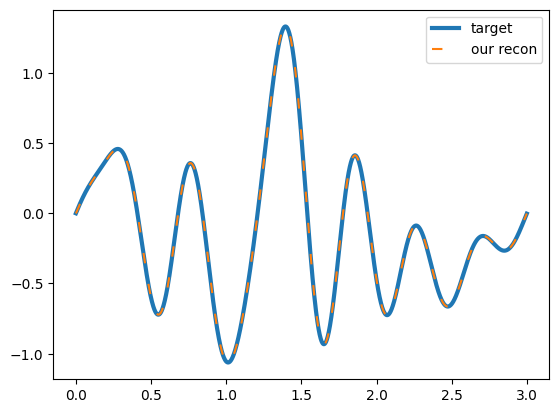

In [161]:
#vals = np.arange(0.0, 3, 1e-3)
plt.plot(values[-len(sig[0]):], sig[0], label='target',linewidth=3,)
#plt.plot(values[-len(recon[:,-1,0]):], recon[:,-1,0], linestyle='--', label='recon', dashes=(5, 5))
plt.plot(values[-len(our_recon[0][-1]):], our_recon[0][-1], linestyle='-', label='our recon', dashes=(5, 10))
plt.legend()

In [163]:
cfs.shape

torch.Size([1, 3000, 64, 1])

In [164]:
coeffs.shape

(3000, 1, 1, 64)

In [166]:
coeffs_out = np.moveaxis(coeffs, 0, 1)
print("Coefs stacked shape:", coeffs_out.shape)
coeffs_out = np.moveaxis(coeffs_out, 2, 3)
print("Coefs stacked shape:", coeffs_out.shape)

Coefs stacked shape: (1, 3000, 1, 64)
Coefs stacked shape: (1, 3000, 64, 1)


In [167]:
cfs

tensor([[[[ 0.0000e+00],
          [ 0.0000e+00],
          [ 0.0000e+00],
          ...,
          [ 0.0000e+00],
          [ 0.0000e+00],
          [ 0.0000e+00]],

         [[ 1.0442e-03],
          [ 1.2057e-03],
          [ 6.6711e-04],
          ...,
          [-2.8104e-19],
          [ 2.7685e-19],
          [-2.7278e-19]],

         [[ 2.2363e-03],
          [ 2.1514e-03],
          [ 5.5474e-04],
          ...,
          [-9.4629e-19],
          [ 9.5765e-19],
          [-6.2370e-19]],

         ...,

         [[-1.3436e-01],
          [-1.1830e-01],
          [ 1.4471e-02],
          ...,
          [-3.3120e-06],
          [ 3.3317e-06],
          [-3.3852e-06]],

         [[-1.3432e-01],
          [-1.1814e-01],
          [ 1.4706e-02],
          ...,
          [-3.3105e-06],
          [ 3.3298e-06],
          [-3.3852e-06]],

         [[-1.3427e-01],
          [-1.1799e-01],
          [ 1.4941e-02],
          ...,
          [-3.3097e-06],
          [ 3.3264e-06],
          

In [169]:
coeffs_out

array([[[[ 0.0000000e+00],
         [ 0.0000000e+00],
         [ 0.0000000e+00],
         ...,
         [ 0.0000000e+00],
         [ 0.0000000e+00],
         [ 0.0000000e+00]],

        [[ 1.0441997e-03],
         [ 1.2057379e-03],
         [ 6.6711480e-04],
         ...,
         [ 9.3220764e-11],
         [-8.0199104e-11],
         [ 6.6280301e-11]],

        [[ 2.2362981e-03],
         [ 2.1514497e-03],
         [ 5.5474316e-04],
         ...,
         [ 1.3331677e-10],
         [-2.5506519e-10],
         [ 3.2492781e-10]],

        ...,

        [[-1.3435808e-01],
         [-1.1829770e-01],
         [ 1.4471100e-02],
         ...,
         [-3.3927831e-06],
         [ 3.5822402e-06],
         [-3.6629956e-06]],

        [[-1.3431503e-01],
         [-1.1814430e-01],
         [ 1.4705439e-02],
         ...,
         [-3.3917993e-06],
         [ 3.5789706e-06],
         [-3.6622514e-06]],

        [[-1.3427113e-01],
         [-1.1798958e-01],
         [ 1.4941187e-02],
         ...,
 

In [172]:
np.allclose(cfs, coeffs_out,  rtol=1e-04, atol=1e-04)

True

### Visualisation 2 batch dimension

In [70]:
vals = np.arange(0.0, 3, 1e-3)
np.random.seed(0)
u = whitesignal(3, 1e-3, 3.0, batch_shape=(2,))
sig, recon, recon_all_t, values = reconstruct(T=3, dt=1e-3, N=64, freq=3.0, vals=vals, u=u)

-------------Input------------
inputs shape: torch.Size([2, 3000])
inputs shape: torch.Size([3000, 2])
inputs shape: torch.Size([3000, 2, 1, 1])
-------------Input------------
-------------Mul u * B------------
U shape: (1, 2, 3000, 1)
self.B_stacked[:L]: torch.Size([3000, 64])
-------------Init------------ torch.Size([2, 1, 64])
Coef c shape: torch.Size([2, 1, 64])
-------------Init------------ torch.Size([2, 1, 64])
part1 shape: torch.Size([2, 1, 64])
part2  shape: torch.Size([2, 1, 64])
A stacked  shape: torch.Size([64, 64])
B stacked  shape: torch.Size([64])
input [f] shape: torch.Size([2, 1, 1])
Coef  c shape: torch.Size([2, 1, 64])
----------------------------------------
----------Reconstruction part:----------
Eval mat shape: torch.Size([3000, 64])
Coefs stacked shape: torch.Size([3000, 2, 1, 64])
Coefs stacked shape: torch.Size([2, 3000, 1, 64])
Coefs stacked shape: torch.Size([2, 3000, 64, 1])
Recon shape: torch.Size([2, 3000, 3000, 1])
---------------------------------------

In [71]:
print(recon.shape)
print(recon_all_t.shape)
print(recon_all_t[0].shape)
print(recon_all_t[0][0].shape)
# print(recon_all_t[0][:,-1,0].shape)

torch.Size([3000, 3000, 1])
torch.Size([2, 3000, 3000, 1])
torch.Size([3000, 3000, 1])
torch.Size([3000, 1])


In [1]:
vals = np.arange(0.0, 3, 1e-3)
plt.plot(values[-len(sig[1]):], sig[1], label='target',linewidth=3,)
#plt.plot(values[-len(recon_all_t[1][-1]):], recon_all_t[1][-1], linestyle='--', label='recon', dashes=(5, 1))
plt.plot(vals[-len(our_recon):], gu_hippo_recon, label='our', dashes=(5, 5))
plt.legend()

NameError: name 'np' is not defined